In [ ]:
import os
import torch
import pandas as pd
import torch.nn as nn
from torchsummary import summary
!pip install transformers
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import DataLoader, Dataset
# torch.cuda.init()
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cpu'
# if torch.cuda.is_available():
#     torch.cuda.set_device(0)  # Set the active CUDA device to index 0

In [10]:
df = pd.read_csv("/content/medical_tc_train_cleaned.csv")
sentences = df["medical_abstract"].tolist()
classes = df['condition_label'].unique()

df

,condition_label,medical_abstract
0,non-cardiovascular,tissue changes around loose prostheses canine ...
1,non-cardiovascular,neuropeptide y and neuronspecific enolase leve...
2,non-cardiovascular,sexually transmitted diseases colon rectum and...
3,non-cardiovascular,lipolytic factors associated with murine and h...
4,non-cardiovascular,does carotid restenosis predict increased risk...
...,...,...
11545,non-cardiovascular,epirubicin at two dose levels with prednisolon...
11546,non-cardiovascular,four and half year follow up women with dyskar...
11547,non-cardiovascular,safety transbronchial biopsy outpatients objec...
11548,non-cardiovascular,interictal spikes and hippocampal somatostatin...


In [ ]:
!pip install sentence-transformers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Create a sample DataFrame


# Perform tokenization and vectorization
vectorizer = TfidfVectorizer()
sentence_vectors = vectorizer.fit_transform(df['medical_abstract'])

# Apply PCA with desired number of components
n_components = 2  # Specify the number of dimensions for the projection
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(sentence_vectors.toarray())

# Apply t-SNE
tsne = TSNE(n_components=2)
tsne_result = tsne.fit_transform(sentence_vectors.toarray())



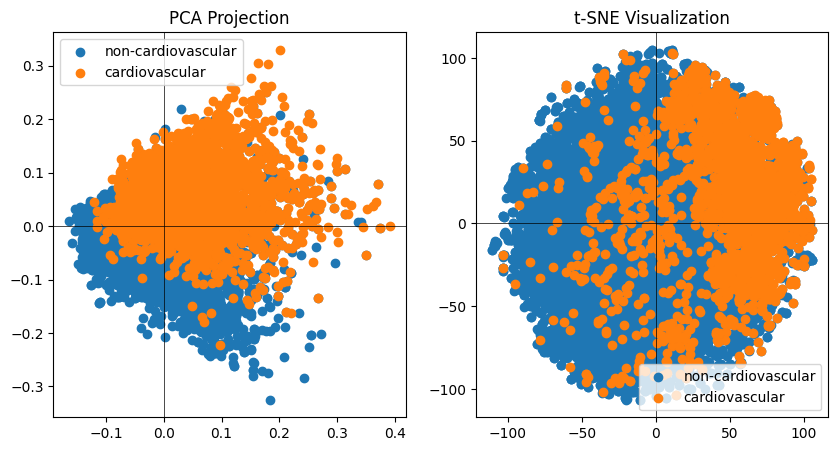

In [12]:

# Plot PCA projection with color coding
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
for cls in classes:
    indices = df[df['condition_label'] == cls].index
    plt.scatter(pca_result[indices, 0], pca_result[indices, 1], label=cls)
plt.title('PCA Projection')
plt.legend()

plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)

#for i, word in enumerate(top_20_words):
#    plt.annotate(word, (pca_result[i, 0], pca_result[i, 1]))

# Plot t-SNE visualization with color coding
plt.subplot(1, 2, 2)
for cls in classes:
    indices = df[df['condition_label'] == cls].index
    plt.scatter(tsne_result[indices, 0], tsne_result[indices, 1], label=cls)
plt.title('t-SNE Visualization')
plt.legend()

#for i, word in enumerate(top_20_words):
#    plt.annotate(word, (pca_result[i, 0], pca_result[i, 1]))

plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)

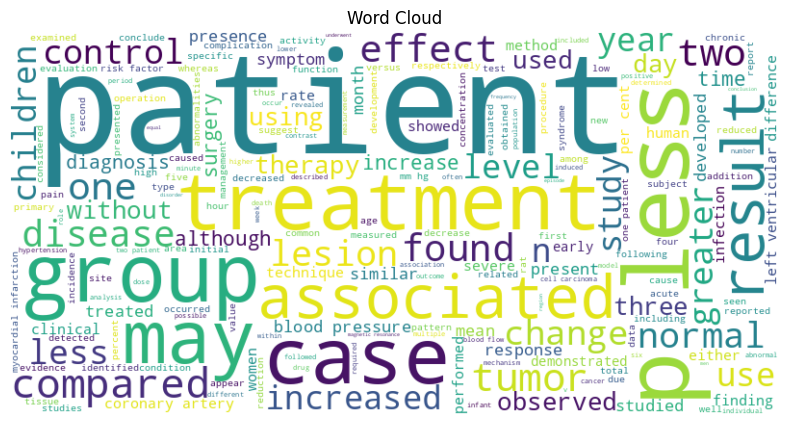

In [13]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create a list of words or sentences

# Concatenate the text into a single string
text_concatenated = ' '.join(sentences)

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_concatenated)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud')
plt.show()


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-v1.1")
model = AutoModel.from_pretrained("dmis-lab/biobert-v1.1")

In [ ]:
train = pd.read_csv("./data/medical_tc_train.csv")
test =  pd.read_csv("./data/medical_tc_test.csv")
labels = pd.read_csv("./data/medical_tc_labels.csv")

In [ ]:
for i, (name, param) in enumerate(model.named_parameters()):
    if i < 175:
        param.requires_grad = False
    else:
        param.requires_grad = True

In [ ]:
# create a custom dataset class for our dataset to be used in dataloader
class MedicalTCDataset(Dataset):
    def __init__(self, data):
        self.data = data['medical_abstract']
        self.labels = data['condition_label']
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        return self.data[index], self.labels[index]

In [ ]:
train_dataset = MedicalTCDataset(train)
test_dataset = MedicalTCDataset(test)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [ ]:
num_classes = 5
classifier = nn.Sequential(
    nn.Linear(model.config.hidden_size, 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, num_classes)
)
class BioBERTClassifier(nn.Module):
    def __init__(self, base_model, classifier):
        super(BioBERTClassifier, self).__init__()
        self.base_model = base_model
        self.classifier = classifier

    def forward(self, input_ids, attention_mask):
        outputs = self.base_model(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        logits = self.classifier(pooled_output)
        return logits

model = BioBERTClassifier(model, classifier)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
num_epochs = 5
num_classes = 5
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
loss_fn = torch.nn.CrossEntropyLoss()

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_dataloader:
        inputs = tokenizer(batch[0], padding=True, truncation=True, return_tensors="pt").to('cuda')
        inputs = {k: v.to(device) for k, v in inputs.items()}
        labels = batch[1].to(device)
        # subtract 1 from labels to have them in range 0-4
        labels = labels - 1
        optimizer.zero_grad()
        outputs = model(inputs['input_ids'], inputs['attention_mask'])
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    average_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {average_loss}")

tensor(1.6224, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5849, device='cuda:0', grad_fn=<NllLossBackward0>)


KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), "./biobert_model_multi_5epoch.pth")

NameError: name 'torch' is not defined